In [1]:
import sys
sys.path.append("../source")

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
from project_lib import *
import pandas as pd

In [4]:
def init_expon_distrib_consensus_data(consensus_data, experiment, N, alpha, R):
    if not ((consensus_data['N'] == N) 
            & (consensus_data['alpha'] == alpha) 
            & (round(consensus_data['eps'],2) == round(R,2))
            ).any():
        consensus_data.at[experiment, "N"] = N
        consensus_data.at[experiment, "alpha"] = alpha
        consensus_data.at[experiment, "eps"] = round(R,2)
        consensus_data.at[experiment, "consensus_x"] = 0
        consensus_data.at[experiment, "consensus_y"] = 0
        consensus_data.at[experiment, "consensus_probabity"] =0
        consensus_data.at[experiment, "simulation_time"] =0
        consensus_data.at[experiment, "simulation_count"] = 0

def update_expon_distrib_consensus_data(consensus_data, experiment, res_arr_fast):
    consensus_data.at[experiment, "consensus_x"] += res_arr_fast[-1, 0, 0]
    consensus_data.at[experiment, "consensus_y"] += res_arr_fast[-1, 0, 1]
    consensus_data.at[experiment, "consensus_probabity"] +=1
    consensus_data.at[experiment, "simulation_time"] +=res_arr_fast.shape[0]
    

dtypes = {
    'N': np.int64,
    'alpha': np.float64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
# consensus_data = pd.DataFrame(columns=["N", "alpha", "eps", "consensus_x", "consensus_y","consensus_probabity", "simulation_time"], dtype=object)
# consensus_data

In [99]:
consensus_data = pd.read_csv('expon_distib_consensus_data.csv', sep=";", dtype=dtypes)
consensus_data

,N,alpha,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
0,50,0.5,0.15,0.000000,0.000000,0.0,0,300
1,50,0.5,0.20,0.000000,0.000000,0.0,0,300
2,50,0.5,0.25,0.414505,0.475757,1.0,17,300
3,50,0.5,0.30,40.737146,39.298339,89.0,842,300
4,50,0.5,0.35,102.827531,103.577089,230.0,1561,300
...,...,...,...,...,...,...,...,...
319,50,0.1,0.80,48.397745,49.727232,100.0,300,100
320,50,0.1,0.85,48.318400,49.395940,100.0,300,100
321,50,0.1,0.90,48.679299,49.197512,100.0,300,100
322,50,0.1,0.95,49.015566,48.496322,100.0,300,100


Мы хотим задать свое распределение - ограничить экспоненциальное отрезком [0,1] и отнормировать

In [7]:
class MyRandomVariableClass(stats.rv_continuous):
    def __init__(self, alpha, xtol=1e-14, seed=None):
        self.alpha = alpha
        super().__init__(a=0, xtol=xtol, seed=seed)

    def _cdf(self, x):
        # alpha = 1
        # return -np.exp(-x*self.alpha) + 1 + np.exp(-self.alpha)*x
        return (1-np.exp(-x*self.alpha))/(1-np.exp(-self.alpha))
    
    def _pdf(self, x):
        # alpha = 1
        # return np.exp(-x*self.alpha)*self.alpha + np.exp(-self.alpha)
        return self.alpha*np.exp(-x*self.alpha)/(1-np.exp(-self.alpha))

    

Проверка

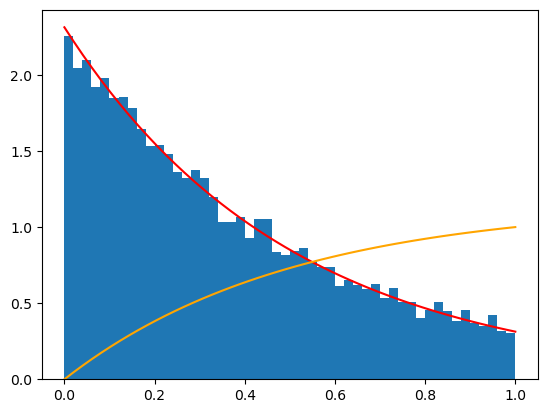

In [18]:

alpha = 2
my_rv1 = MyRandomVariableClass(alpha)

# sample distribution
samples = my_rv1.rvs(size = 10000)

# plot histogram of samples
fig, ax1 = plt.subplots()
ax1.hist(list(samples), bins=50, density=True)

# plot PDF and CDF of distribution
pts = np.linspace(0, 1)
ax1.plot(pts, my_rv1.pdf(pts), color='red')
ax1.plot(pts, my_rv1.cdf(pts), color='orange')
# ax1.plot(pts, np.exp(-pts*alpha)*alpha + np.exp(-alpha), color='green')


plt.show()

In [8]:
R = 0.2  # радиус доверия
eps = 1e-4  # допустимая точность
n = 50  # количество агентов по одной оси
N = n

In [9]:
R_array = [round(i,2)for i in np.arange(0.15, 1.01, 0.05)]
params_array =  np.arange(0.5, 5.1, 0.5)
params_array

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [28]:
import numpy as np
def expon_distrib_a2Esigma(alpha):
    e2ma = np.exp(-alpha)
    E = 1 / (1 - e2ma) * (-e2ma - 1/alpha * e2ma + 1/alpha)
    Ex2 = (1 / (1 - e2ma)) * (-e2ma - 2.0/alpha * e2ma - 2.0/(alpha**2) * e2ma + 2.0/(alpha**2))
    return E, Ex2 - E**2

def expon_distrib_Esigma2a(E, sigma):
    Ex2 = sigma +E**2
    # a1 = 2*E +1 + np.sqrt(1-4*E**2 -2*E-4*E*Ex2)
    # a2 = 2*E +1 + np.sqrt(4*E**2+1 + 4*Ex2)
    a3 = (Ex2 - E) / (2*E - 1)
    return 1/a3

In [54]:
my_rv1.mean(), my_rv1.std()

(0.3434823572503395, 0.26264916668137156)

In [37]:
a=3
E, D = expon_distrib_a2Esigma(a)
E, D

(0.2809376368420774, 0.055970105609051315)

In [38]:
expon_distrib_Esigma2a(E, D)

2.9999999999999987

In [39]:
delta = [round(i,2)for i in np.arange(0.05, 0.41, 0.1)]
delta

[0.05, 0.15, 0.25, 0.35]

In [88]:
mu = []
mean=0.5
for i in delta:
    mu.append(round(mean-i,2))
    mu.append(round(mean+i,2))
mu.append(0.49)
mu

[0.45, 0.55, 0.35, 0.65, 0.25, 0.75, 0.15, 0.85, 0.49]

In [89]:
sigma=0.049
params_array=[]
for m in mu:
    a = expon_distrib_Esigma2a(m, sigma)
    params_array.append(round(a,2))
params_array

[0.5, -0.5, 1.68, -1.68, 3.61, -3.61, 8.92, -8.92, 0.1]

In [90]:
m, d = expon_distrib_a2Esigma(np.array(params_array))
m

array([0.45850592, 0.54149408, 0.3661722 , 0.6338278 , 0.24920431,
       0.75079569, 0.11197392, 0.88802608, 0.49166806])

In [74]:
experiments = 100

In [92]:
experiment = consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5

for i in range (len(params_array)):
    alpha = params_array[i]
    my_rv = MyRandomVariableClass(alpha)
    for R in R_array:
        init_expon_distrib_consensus_data(consensus_data, experiment, N, alpha, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = my_rv.rvs(size = (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = consensus_data[
                    ((consensus_data['N'] == N) 
                    & (consensus_data['alpha'] == alpha) 
                    & (round(consensus_data['eps'],2) == round(R,2)))].index[0]
                consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_expon_distrib_consensus_data(consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = consensus_data.index[-1] +1

N:50 R:0.15 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


N:50 R:0.2 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 22.51it/s]


N:50 R:0.25 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


N:50 R:0.3 a:0.5 func:HK_2D_sim_fast count:1


100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


N:50 R:0.35 a:0.5 func:HK_2D_sim count:31


100%|██████████| 100/100 [00:04<00:00, 21.17it/s]


N:50 R:0.4 a:0.5 func:HK_2D_sim count:107


100%|██████████| 100/100 [00:04<00:00, 21.42it/s]


N:50 R:0.45 a:0.5 func:HK_2D_sim count:204


100%|██████████| 100/100 [00:04<00:00, 21.77it/s]


N:50 R:0.5 a:0.5 func:HK_2D_sim count:304


100%|██████████| 100/100 [00:04<00:00, 21.78it/s]


N:50 R:0.55 a:0.5 func:HK_2D_sim count:404


100%|██████████| 100/100 [00:04<00:00, 21.79it/s]


N:50 R:0.6 a:0.5 func:HK_2D_sim count:504


100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


N:50 R:0.65 a:0.5 func:HK_2D_sim count:604


100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


N:50 R:0.7 a:0.5 func:HK_2D_sim count:704


100%|██████████| 100/100 [00:04<00:00, 21.86it/s]


N:50 R:0.75 a:0.5 func:HK_2D_sim count:804


100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


N:50 R:0.8 a:0.5 func:HK_2D_sim count:904


100%|██████████| 100/100 [00:04<00:00, 21.85it/s]


N:50 R:0.85 a:0.5 func:HK_2D_sim count:1004


100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


N:50 R:0.9 a:0.5 func:HK_2D_sim count:1104


100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


N:50 R:0.95 a:0.5 func:HK_2D_sim count:1204


100%|██████████| 100/100 [00:04<00:00, 21.69it/s]


N:50 R:1.0 a:0.5 func:HK_2D_sim count:1304


100%|██████████| 100/100 [00:04<00:00, 22.00it/s]


N:50 R:0.15 a:-0.5 func:HK_2D_sim count:1404


100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


N:50 R:0.2 a:-0.5 func:HK_2D_sim count:1404


100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


N:50 R:0.25 a:-0.5 func:HK_2D_sim count:1404


100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


N:50 R:0.3 a:-0.5 func:HK_2D_sim count:1405


100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


N:50 R:0.35 a:-0.5 func:HK_2D_sim count:1426


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


N:50 R:0.4 a:-0.5 func:HK_2D_sim count:1506


100%|██████████| 100/100 [00:07<00:00, 14.14it/s]


N:50 R:0.45 a:-0.5 func:HK_2D_sim count:1603


100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


N:50 R:0.5 a:-0.5 func:HK_2D_sim count:1702


100%|██████████| 100/100 [00:07<00:00, 14.18it/s]


N:50 R:0.55 a:-0.5 func:HK_2D_sim count:1802


100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


N:50 R:0.6 a:-0.5 func:HK_2D_sim count:1902


100%|██████████| 100/100 [00:07<00:00, 14.29it/s]


N:50 R:0.65 a:-0.5 func:HK_2D_sim count:2002


100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


N:50 R:0.7 a:-0.5 func:HK_2D_sim count:2102


100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


N:50 R:0.75 a:-0.5 func:HK_2D_sim count:2202


100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


N:50 R:0.8 a:-0.5 func:HK_2D_sim count:2302


100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


N:50 R:0.85 a:-0.5 func:HK_2D_sim count:2402


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


N:50 R:0.9 a:-0.5 func:HK_2D_sim count:2502


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


N:50 R:0.95 a:-0.5 func:HK_2D_sim count:2602


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


N:50 R:1.0 a:-0.5 func:HK_2D_sim count:2702


100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


N:50 R:0.15 a:1.68 func:HK_2D_sim count:2802


100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


N:50 R:0.2 a:1.68 func:HK_2D_sim count:2802


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


N:50 R:0.25 a:1.68 func:HK_2D_sim count:2802


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


N:50 R:0.3 a:1.68 func:HK_2D_sim count:2803


100%|██████████| 100/100 [00:10<00:00,  9.28it/s]


N:50 R:0.35 a:1.68 func:HK_2D_sim count:2819


100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


N:50 R:0.4 a:1.68 func:HK_2D_sim count:2878


100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


N:50 R:0.45 a:1.68 func:HK_2D_sim count:2964


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


N:50 R:0.5 a:1.68 func:HK_2D_sim count:3059


100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


N:50 R:0.55 a:1.68 func:HK_2D_sim count:3158


100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


N:50 R:0.6 a:1.68 func:HK_2D_sim count:3258


100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


N:50 R:0.65 a:1.68 func:HK_2D_sim count:3358


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


N:50 R:0.7 a:1.68 func:HK_2D_sim count:3458


100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


N:50 R:0.75 a:1.68 func:HK_2D_sim count:3558


100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


N:50 R:0.8 a:1.68 func:HK_2D_sim count:3658


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


N:50 R:0.85 a:1.68 func:HK_2D_sim count:3758


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


N:50 R:0.9 a:1.68 func:HK_2D_sim count:3858


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


N:50 R:0.95 a:1.68 func:HK_2D_sim count:3958


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


N:50 R:1.0 a:1.68 func:HK_2D_sim count:4058


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


N:50 R:0.15 a:-1.68 func:HK_2D_sim count:4158


100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


N:50 R:0.2 a:-1.68 func:HK_2D_sim count:4158


100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


N:50 R:0.25 a:-1.68 func:HK_2D_sim count:4158


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


N:50 R:0.3 a:-1.68 func:HK_2D_sim count:4159


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


N:50 R:0.35 a:-1.68 func:HK_2D_sim count:4173


100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


N:50 R:0.4 a:-1.68 func:HK_2D_sim count:4224


100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


N:50 R:0.45 a:-1.68 func:HK_2D_sim count:4316


100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


N:50 R:0.5 a:-1.68 func:HK_2D_sim count:4415


100%|██████████| 100/100 [00:13<00:00,  7.64it/s]


N:50 R:0.55 a:-1.68 func:HK_2D_sim count:4515


100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


N:50 R:0.6 a:-1.68 func:HK_2D_sim count:4615


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


N:50 R:0.65 a:-1.68 func:HK_2D_sim count:4715


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


N:50 R:0.7 a:-1.68 func:HK_2D_sim count:4815


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


N:50 R:0.75 a:-1.68 func:HK_2D_sim count:4915


100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


N:50 R:0.8 a:-1.68 func:HK_2D_sim count:5015


100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


N:50 R:0.85 a:-1.68 func:HK_2D_sim count:5115


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


N:50 R:0.9 a:-1.68 func:HK_2D_sim count:5215


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


N:50 R:0.95 a:-1.68 func:HK_2D_sim count:5315


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


N:50 R:1.0 a:-1.68 func:HK_2D_sim count:5415


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


N:50 R:0.15 a:3.61 func:HK_2D_sim count:5515


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


N:50 R:0.2 a:3.61 func:HK_2D_sim count:5515


100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


N:50 R:0.25 a:3.61 func:HK_2D_sim count:5516


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


N:50 R:0.3 a:3.61 func:HK_2D_sim count:5519


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


N:50 R:0.35 a:3.61 func:HK_2D_sim count:5526


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


N:50 R:0.4 a:3.61 func:HK_2D_sim count:5575


100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


N:50 R:0.45 a:3.61 func:HK_2D_sim count:5643


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


N:50 R:0.5 a:3.61 func:HK_2D_sim count:5732


100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


N:50 R:0.55 a:3.61 func:HK_2D_sim count:5827


100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


N:50 R:0.6 a:3.61 func:HK_2D_sim count:5926


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


N:50 R:0.65 a:3.61 func:HK_2D_sim count:6026


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


N:50 R:0.7 a:3.61 func:HK_2D_sim count:6126


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


N:50 R:0.75 a:3.61 func:HK_2D_sim count:6225


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


N:50 R:0.8 a:3.61 func:HK_2D_sim count:6325


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


N:50 R:0.85 a:3.61 func:HK_2D_sim count:6425


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


N:50 R:0.9 a:3.61 func:HK_2D_sim count:6525


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


N:50 R:0.95 a:3.61 func:HK_2D_sim count:6625


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


N:50 R:1.0 a:3.61 func:HK_2D_sim count:6725


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


N:50 R:0.15 a:-3.61 func:HK_2D_sim count:6825


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


N:50 R:0.2 a:-3.61 func:HK_2D_sim count:6825


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


N:50 R:0.25 a:-3.61 func:HK_2D_sim count:6825


100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


N:50 R:0.3 a:-3.61 func:HK_2D_sim count:6827


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


N:50 R:0.35 a:-3.61 func:HK_2D_sim count:6841


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


N:50 R:0.4 a:-3.61 func:HK_2D_sim count:6891


100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


N:50 R:0.45 a:-3.61 func:HK_2D_sim count:6960


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


N:50 R:0.5 a:-3.61 func:HK_2D_sim count:7047


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


N:50 R:0.55 a:-3.61 func:HK_2D_sim count:7142


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


N:50 R:0.6 a:-3.61 func:HK_2D_sim count:7238


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


N:50 R:0.65 a:-3.61 func:HK_2D_sim count:7337


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


N:50 R:0.7 a:-3.61 func:HK_2D_sim count:7437


100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


N:50 R:0.75 a:-3.61 func:HK_2D_sim count:7537


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


N:50 R:0.8 a:-3.61 func:HK_2D_sim count:7637


100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


N:50 R:0.85 a:-3.61 func:HK_2D_sim count:7737


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


N:50 R:0.9 a:-3.61 func:HK_2D_sim count:7837


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


N:50 R:0.95 a:-3.61 func:HK_2D_sim count:7937


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


N:50 R:1.0 a:-3.61 func:HK_2D_sim count:8037


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


N:50 R:0.15 a:8.92 func:HK_2D_sim count:8137


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


N:50 R:0.2 a:8.92 func:HK_2D_sim count:8145


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


N:50 R:0.25 a:8.92 func:HK_2D_sim count:8162


100%|██████████| 100/100 [00:06<00:00, 14.97it/s]


N:50 R:0.3 a:8.92 func:HK_2D_sim count:8211


100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


N:50 R:0.35 a:8.92 func:HK_2D_sim count:8282


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


N:50 R:0.4 a:8.92 func:HK_2D_sim count:8367


100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


N:50 R:0.45 a:8.92 func:HK_2D_sim count:8452


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


N:50 R:0.5 a:8.92 func:HK_2D_sim count:8544


100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


N:50 R:0.55 a:8.92 func:HK_2D_sim count:8641


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


N:50 R:0.6 a:8.92 func:HK_2D_sim count:8740


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


N:50 R:0.65 a:8.92 func:HK_2D_sim count:8840


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


N:50 R:0.7 a:8.92 func:HK_2D_sim count:8940


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


N:50 R:0.75 a:8.92 func:HK_2D_sim count:9040


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


N:50 R:0.8 a:8.92 func:HK_2D_sim count:9140


100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


N:50 R:0.85 a:8.92 func:HK_2D_sim count:9240


100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


N:50 R:0.9 a:8.92 func:HK_2D_sim count:9340


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


N:50 R:0.95 a:8.92 func:HK_2D_sim count:9440


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


N:50 R:1.0 a:8.92 func:HK_2D_sim count:9540


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


N:50 R:0.15 a:-8.92 func:HK_2D_sim count:9640


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


N:50 R:0.2 a:-8.92 func:HK_2D_sim count:9645


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


N:50 R:0.25 a:-8.92 func:HK_2D_sim count:9665


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


N:50 R:0.3 a:-8.92 func:HK_2D_sim count:9714


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


N:50 R:0.35 a:-8.92 func:HK_2D_sim count:9781


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


N:50 R:0.4 a:-8.92 func:HK_2D_sim count:9867


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


N:50 R:0.45 a:-8.92 func:HK_2D_sim count:9954


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


N:50 R:0.5 a:-8.92 func:HK_2D_sim count:10046


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


N:50 R:0.55 a:-8.92 func:HK_2D_sim count:10141


100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


N:50 R:0.6 a:-8.92 func:HK_2D_sim count:10241


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


N:50 R:0.65 a:-8.92 func:HK_2D_sim count:10341


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


N:50 R:0.7 a:-8.92 func:HK_2D_sim count:10441


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


N:50 R:0.75 a:-8.92 func:HK_2D_sim count:10541


100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


N:50 R:0.8 a:-8.92 func:HK_2D_sim count:10641


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


N:50 R:0.85 a:-8.92 func:HK_2D_sim count:10741


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


N:50 R:0.9 a:-8.92 func:HK_2D_sim count:10841


100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


N:50 R:0.95 a:-8.92 func:HK_2D_sim count:10941


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


N:50 R:1.0 a:-8.92 func:HK_2D_sim count:11041


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


N:50 R:0.15 a:0.1 func:HK_2D_sim count:11141


100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


N:50 R:0.2 a:0.1 func:HK_2D_sim count:11141


100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


N:50 R:0.25 a:0.1 func:HK_2D_sim count:11141


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


N:50 R:0.3 a:0.1 func:HK_2D_sim count:11141


100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


N:50 R:0.35 a:0.1 func:HK_2D_sim count:11164


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


N:50 R:0.4 a:0.1 func:HK_2D_sim count:11243


100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


N:50 R:0.45 a:0.1 func:HK_2D_sim count:11342


100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


N:50 R:0.5 a:0.1 func:HK_2D_sim count:11441


100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


N:50 R:0.55 a:0.1 func:HK_2D_sim count:11541


100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


N:50 R:0.6 a:0.1 func:HK_2D_sim count:11641


100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


N:50 R:0.65 a:0.1 func:HK_2D_sim count:11741


100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


N:50 R:0.7 a:0.1 func:HK_2D_sim count:11841


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


N:50 R:0.75 a:0.1 func:HK_2D_sim count:11941


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


N:50 R:0.8 a:0.1 func:HK_2D_sim count:12041


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


N:50 R:0.85 a:0.1 func:HK_2D_sim count:12141


100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


N:50 R:0.9 a:0.1 func:HK_2D_sim count:12241


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


N:50 R:0.95 a:0.1 func:HK_2D_sim count:12341


100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


N:50 R:1.0 a:0.1 func:HK_2D_sim count:12441


100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_22524\3277233645.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_22524\3277233645.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_22524\3277233645.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or 

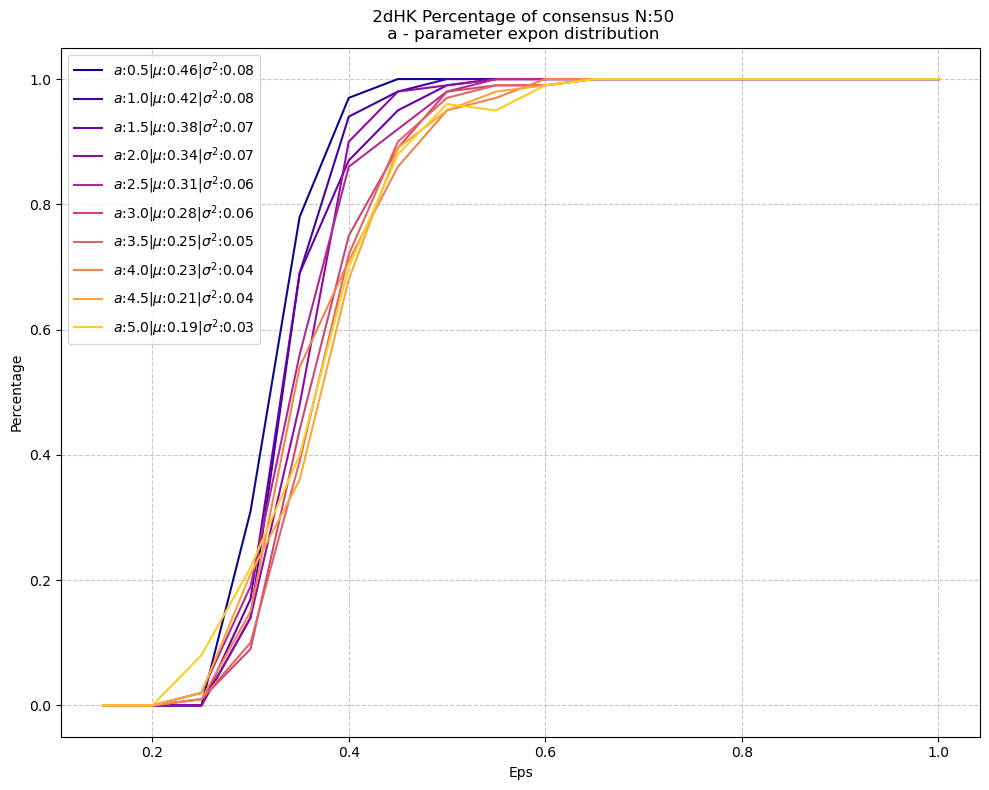

In [11]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=min(params_array), vmax=max(params_array)+0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for i in range (len(params_array)):
    alpha = params_array[i]
    df = consensus_data.query('alpha==@alpha and N == @N')
    color=np.array(cmap(norm(alpha)))
    E, sigma = expon_distrib_a2Esigma(alpha)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

# plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a - parameter expon distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [98]:
consensus_data.to_csv('expon_distib_consensus_data.csv',sep=";", index=False)

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_22524\2717744121.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_22524\2717744121.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_22524\2717

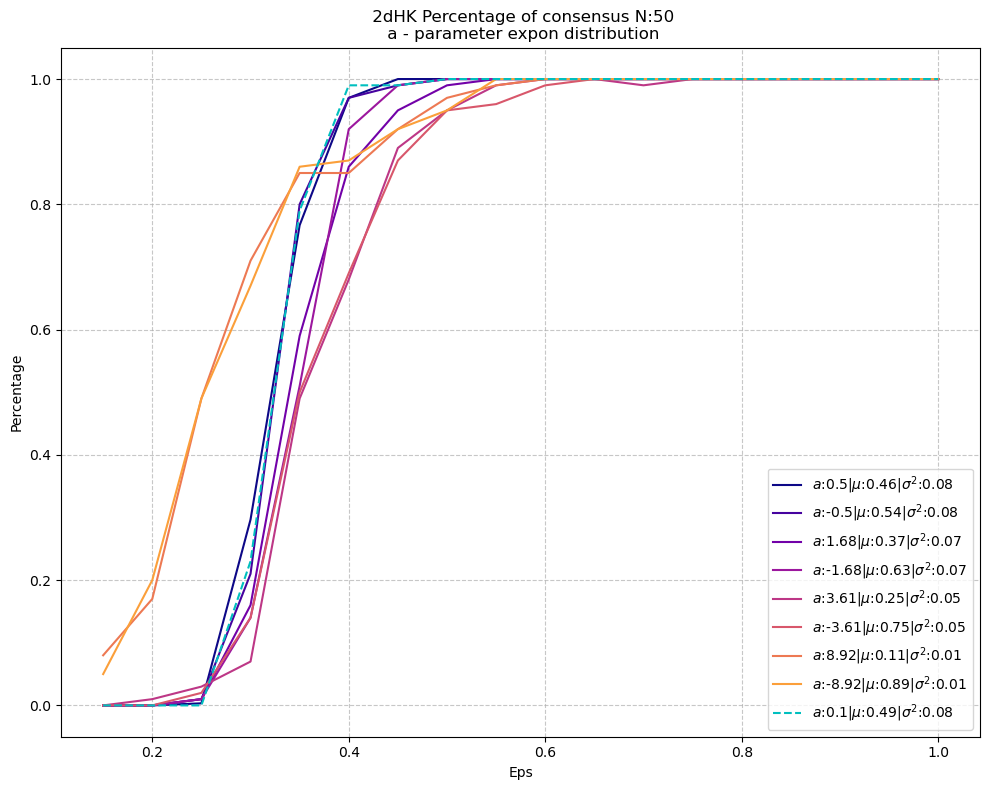

In [97]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0, vmax=len(params_array))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for i in range (len(params_array[:-1])):
    alpha = params_array[i]
    df = consensus_data.query('alpha==@alpha and N == @N')
    color=np.array(cmap(norm(i)))
    E, sigma = expon_distrib_a2Esigma(alpha)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
alpha = params_array[-1]
df = consensus_data.query('alpha==@alpha and N == @N')
color="--c"
E, sigma = expon_distrib_a2Esigma(a)
plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], color ,label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a - parameter expon distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()